In [ ]:
from google.colab import drive


drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os                       # for working with files
import numpy as np              # for numerical computationss
import pandas as pd             # for working with dataframes
import seaborn as sns
import torch                    # Pytorch module
import matplotlib.pyplot as plt # for plotting informations on graph and images using tensors
import torch.nn as nn           # for creating  neural networks
from torch.utils.data import DataLoader # for dataloaders
from PIL import Image           # for checking images
import torch.nn.functional as F # for functions for calculating loss
import torchvision.transforms as transforms   # for transforming images into tensors
from torchvision.utils import make_grid       # for data checking
from torchvision.datasets import ImageFolder  # for working with classes and images
from torchsummary import summary              # for getting the summary of our model
import tensorflow as tf
from  tensorflow import keras
import itertools
from sklearn.metrics import precision_score, accuracy_score, recall_score, confusion_matrix, ConfusionMatrixDisplay

%matplotlib inline

In [ ]:

lung_dir = "/content/drive/MyDrive/lung_image_sets_actual/"
classes = os.listdir(lung_dir)

In [ ]:
path_to_split = "/content/drive/MyDrive/lung_image_sets_newsplit/"
test_size = 0.2
import shutil
from sklearn.model_selection import train_test_split
for class_name in classes:
    images = os.listdir(lung_dir+class_name)
    train_images, test_images = train_test_split(images, test_size=test_size)

    # Create the train and test directories if they don't exist
    if not os.path.exists(path_to_split + "train/" + class_name):
        os.makedirs(path_to_split + "train/" + class_name)
    if not os.path.exists(path_to_split + "test/" + class_name):
        os.makedirs(path_to_split + "test/" + class_name)

    # Copy the images to the train and test directories
    for image in train_images:
        src = lung_dir + class_name + "/" + image
        dst = path_to_split + "train/" + class_name + "/" + image
        shutil.copyfile(src, dst)
    for image in test_images:
        src = lung_dir + class_name + "/" + image
        dst = path_to_split + "test/" + class_name + "/" + image
        shutil.copyfile(src, dst)

In [ ]:
train_gen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255,
                                                         rotation_range = 20 ,
                                                         horizontal_flip = True ,
                                                         validation_split = 0.2
                                                         )

valid_gen =  keras.preprocessing.image.ImageDataGenerator(rescale=1./255,validation_split = 0.2)
train_data = train_gen.flow_from_directory("/content/drive/MyDrive/lung_image_sets_newsplit/train", subset='training', target_size=(224,224), batch_size=16, color_mode='rgb',
                                            class_mode='categorical', shuffle=True)
y_train = train_data.classes
val_data = valid_gen.flow_from_directory("/content/drive/MyDrive/lung_image_sets_newsplit/train", subset='validation', target_size=(224,224), batch_size=16, color_mode='rgb',
                                            class_mode='categorical', shuffle=False)
y_val = val_data.classes

In [ ]:
class ChannelAttention(tf.keras.layers.Layer):
    def __init__(self, filters, ratio=8, **kwargs):
        super(ChannelAttention, self).__init__(**kwargs)
        self.filters = filters
        self.ratio = ratio
        print(filters)

    def build(self, input_shape):
        self.shared_layer_one = tf.keras.layers.Dense(
            self.filters // self.ratio,
            activation='relu',
            kernel_initializer='he_normal',
            use_bias=True,
            bias_initializer='zeros'
        )
        self.shared_layer_two = tf.keras.layers.Dense(
            self.filters,
            kernel_initializer='he_normal',
            use_bias=True,
            bias_initializer='zeros'
        )

    def call(self, inputs):

        avg_pool = tf.keras.layers.GlobalAveragePooling2D()(inputs)
        print(avg_pool.shape)
        avg_pool = tf.keras.layers.Reshape((1, 1, self.filters))(avg_pool)
        avg_pool = self.shared_layer_one(avg_pool)
        avg_pool = self.shared_layer_two(avg_pool)


        max_pool = tf.keras.layers.GlobalMaxPooling2D()(inputs)

        max_pool = tf.keras.layers.Reshape((1, 1, self.filters))(max_pool)

        max_pool = self.shared_layer_one(max_pool)
        max_pool = self.shared_layer_two(max_pool)


        attention = tf.keras.layers.Add()([avg_pool, max_pool])
        attention = tf.keras.layers.Activation('sigmoid')(attention)


        return tf.keras.layers.Multiply()([inputs, attention])

    def compute_output_shape(self, input_shape):
        return input_shape

    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'filters': self.filters,
            'ratio': self.ratio,
        })
        return config


In [ ]:
!pip install numpy
!pip install sklearn
!pip install matplotlib
!pip install ReliefF
!pip install -U Py_FS==0.2.0


In [ ]:
from keras.models import Model
from keras.models import Sequential
from keras.layers import Flatten,Dense,Dropout,Attention,Conv2D,MaxPool2D,GlobalAveragePooling2D,Input,ZeroPadding2D,AvgPool2D,Activation,MaxPooling2D,AveragePooling2D
from keras.layers import Input, BatchNormalization
from keras.layers import ReLU, concatenate
import keras.backend as Kback
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50
from keras.applications.densenet import DenseNet121
from keras.applications.inception_v3 import InceptionV3
from keras.applications.inception_resnet_v2 import InceptionResNetV2
import matplotlib.pyplot as plot
from glob import glob
import tensorflow as tf
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
from keras import layers




In [ ]:
densenet_model=tf.keras.applications.densenet.DenseNet121(include_top= False,input_shape=(224,224,3), weights='imagenet' )
for each_layer in densenet_model.layers:
    each_layer.trainable = False

In [ ]:
x= ChannelAttention(32,3)(densenet_model.output)
flatten_layer = Flatten()(x)

d1= Dense(512, activation='relu')(flatten_layer)

d2= Dense(128, activation='relu')(d1)

output = Dense(3, activation='softmax')(d2)

final_model = Model(inputs=densenet_model.input, outputs=output)
final_model.summary()

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.01)
final_model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
keras.utils.plot_model(
    final_model,
    to_file="model.png",
    show_shapes=False,
    show_dtype=False,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=False,
    dpi=96,
    layer_range=None,
    show_layer_activations=False,
)

In [ ]:
fitted_model = final_model.fit(
  train_data,
  validation_data=val_data,

  epochs=25,
  steps_per_epoch=len(train_data),
  validation_steps=len(val_data)
)

final_model.save('/content/drive/MyDrive/Model_weight_data/feature_selection.h5')

In [ ]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

test_data = test_datagen.flow_from_directory(
    "/content/drive/MyDrive/lung_image_sets_newsplit/test",
    target_size=(224, 224),
    batch_size=32,
    shuffle = False,
    class_mode='categorical')


In [ ]:
final_model.evaluate(test_data)

In [ ]:
all_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
all_data = all_datagen.flow_from_directory("/content/drive/MyDrive/lung_image_sets_newsplit/train", target_size=(224,224), batch_size=16, color_mode='rgb',
                                            class_mode='categorical', shuffle=False)
y_all = all_data.classes

In [ ]:
from tensorflow.keras.utils import custom_object_scope
from tensorflow.keras.models import load_model
with custom_object_scope({'ChannelAttention': ChannelAttention}):
  loaded_model = load_model('/content/drive/MyDrive/Model_weight_data/feature_selection.h5')

In [ ]:
loss = loaded_model.evaluate(test_data)

In [ ]:
adam = tf.keras.optimizers.Adam(learning_rate=0.01)
loaded_model.compile(
  loss='categorical_crossentropy',
  optimizer='adam',
  metrics=['accuracy']
)

In [ ]:
import pickle

plt.plot(loaded_model.history.history['accuracy'], label='Training Accuracy')
plt.plot(loaded_model.history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
model2 = Model(loaded_model.input,loaded_model.layers[-2].output)
train_feature = model2.predict(all_data)

test_feature = model2.predict(test_data)

In [ ]:
from sklearn.metrics import classification_report

Y_pred = loaded_model.predict(test_data)
y_pred = np.argmax(Y_pred, axis=-1)

y_test = test_data.classes


In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:

import seaborn as sns

from sklearn.metrics import accuracy_score,classification_report,confusion_matrix
print(accuracy_score(y_test,y_pred))
print(classification_report(y_test,y_pred))
cm= confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.viridis_r, cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, yticklabels=classes, title="LUNG CANCER CLASSIFICATION")
plt.yticks(rotation=0)
plt.xticks(rotation=0)

In [ ]:
#  # print(type(df))
predictions_df = pd.DataFrame(train_feature)
test_predictions_df = pd.DataFrame(test_feature)

In [ ]:
predictions_df.head()

In [ ]:
from google.colab import files
predictions_df.to_csv('output.csv', encoding = 'utf-8-sig')
files.download('output.csv')
test_predictions_df.to_csv('test_output.csv', encoding = 'utf-8-sig')
files.download('test_output.csv')

In [ ]:
predictions_df = pd.read_csv("/content/drive/MyDrive/feature/output.csv", index_col=[0])
test_predictions_df = pd.read_csv("/content/drive/MyDrive/feature/test_output.csv", index_col=[0])

In [ ]:
!pip3 install skfeature-chappers
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from collections import Counter
from sklearn.utils import resample
from skfeature.function.similarity_based import fisher_score

In [ ]:
import random
import math,time,sys, os
from matplotlib import pyplot
from datetime import datetime

In [ ]:
dataframe=pd.concat([predictions_df,test_predictions_df])

In [ ]:
y_all

In [ ]:
type(y_test)

In [ ]:
y = np.append(y_all,y_test)

In [ ]:
cols=[]
for i in range(len(dataframe.columns)):
  col1=dataframe[dataframe.columns[i]].to_numpy()
  if(np.sum(col1)==0):
    cols.append(dataframe.columns[i])

dataframe = dataframe.drop(columns=cols)
print(dataframe.shape[1])

In [ ]:
# print(predictions_df.shape)
# print(test_predictions_df.shape)
# print(y_test.shape)
# print(y_all.shape)

In [ ]:
df=dataframe.copy()
df['labels']=y
# df

In [ ]:
from google.colab import files
df.to_csv('complete_output.csv', encoding = 'utf-8-sig')
files.download('complete_output.csv')

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/complete_output.csv", index_col=[0])

In [ ]:
# df

In [ ]:
def sort_agents(agents, obj,train_X,val_X,train_Y,val_Y):
    # sort the agents according to fitness
    #train_X, val_X, train_Y, val_Y = data.train_X, data.val_X, data.train_Y, data.val_Y
    (obj_function, weight_acc) = obj

    # if there is only one agent
    # print("agent.shape")
    # print(agents.shape)
    if len(agents.shape) == 1:
        num_agents = 1
        fitness = obj_function(agents, train_X, val_X, train_Y, val_Y, weight_acc)
        return agents, fitness

    # for multiple agents
    else:
        num_agents = agents.shape[0]
        fitness = np.zeros(num_agents)
        for id, agent in enumerate(agents):
            fitness[id] = obj_function(agent, train_X, val_X, train_Y, val_Y, weight_acc)

        idx = np.argsort(-fitness)
        sorted_agents = agents[idx].copy()
        sorted_fitness = fitness[idx].copy()

    return sorted_agents, sorted_fitness

In [ ]:
def compute_fitness(agent, train_X, test_X, train_Y, test_Y, weight_acc=0.99):
    # compute a basic fitness measure
    if(weight_acc == None):
        weight_acc = 0.99

    weight_feat = 1 - weight_acc
    num_features = len(agent)

    acc = compute_accuracy(agent, train_X, test_X, train_Y, test_Y)
    feat = (num_features - np.sum(agent))/num_features

    fitness = weight_acc * acc + weight_feat * feat

    return fitness

In [ ]:
from sklearn.feature_selection import f_regression

# inputs:
#    X: pandas.DataFrame, features
#    yy: pandas.Series, target variable
#    K: number of features to select


X=x
yy=df[str].to_numpy()
K=x.shape[1]

# compute F-statistics and initialize correlation matrix
F = pd.Series(f_regression(X, yy)[0], index = X.columns)
corr = pd.DataFrame(.00001, index = X.columns, columns = X.columns)

# initialize list of selected features and list of excluded features
selected = []
not_selected = X.columns.to_list()
Dict={}
# repeat K times
for i in range(K):

    # compute (absolute) correlations between the last selected feature and all the (currently) excluded features
    if i > 0:
        last_selected = selected[-1]
        corr.loc[not_selected, last_selected] = X[not_selected].corrwith(X[last_selected]).abs().clip(.00001)

    # compute FCQ score for all the (currently) excluded features (this is Formula 2)
    score = F.loc[not_selected] / corr.loc[not_selected, selected].mean(axis = 1).fillna(.00001)

    # find best feature, add it to selected and remove it from not_selected
    # print(score[score.argmax()])
    # print(score.max())
    # print(score.index[score.argmax()])
    best = score.index[score.argmax()]
    selected.append(best)
    not_selected.remove(best)
    Dict[best]=score.max()

mrMr=[]
for i in range(x.shape[1]):
  mrMr.append(Dict[x.columns[i]])

In [ ]:
for i in range(len(mrMr)):
  mrMr[i]=mrMr[i]/(max(mrMr))

In [ ]:
def normalize(arr, t_min, t_max):
    norm_arr = []
    diff = t_max - t_min
    diff_arr = max(arr) - min(arr)
    for i in arr:
        temp = (((i - min(arr))*diff)/diff_arr) + t_min
        norm_arr.append(temp)
    return norm_arr

In [ ]:
import copy
from abc import abstractmethod
from Py_FS.filter._utilities import normalize, Result

class Algorithm():
    def __init__(self,
                data,
                target,
                default_mode=False,
                verbose=False):

        self.data = np.array(data)
        self.target = target
        self.num_features = self.data.shape[1]
        self.feature_scores = None
        self.feature_ranks = None
        self.ranked_features = None
        self.verbose = verbose
        self.print = self.verboseprint()
        self.algo_params = None
        self.default_mode = default_mode
        self.algo_params = {}

    @abstractmethod
    def user_input(self):
        pass

    def set_default(self):
        list_keys = list(self.default_vals.keys())
        for key in list_keys:
            self.algo_params[key] = self.default_vals[key]




    def run(self):
        self.user_input()
        self.initialize()
        self.execute()
        self.feature_ranks = np.argsort(np.argsort(-self.scores))
        self.ranked_features = self.data[:, self.feature_ranks]

        return self

    def verboseprint(self):
        if self.verbose:
            def mod_print(*args, end="\n"):
                for arg in args:
                    print(arg, end=end),
                print
        else:
            def mod_print(*args, end="\n"):
                pass

        return mod_print



In [ ]:
from Py_FS.filter._utilities import normalize, Result
from sklearn import datasets

class PCC(Algorithm):
    def __init__(self,
                data,
                target,
                default_mode=False,
                verbose=True):

        super().__init__(
            data=data,
            target=target,
            default_mode=default_mode,
            verbose=verbose
        )

    def user_input(self):
        if self.default_mode:
            self.set_default()
        else:
            self.algo_params["weight_feat"] = 0.3
            self.algo_params["weight_class"] =  0.7

    def initialize(self):
        self.correlation_matrix = np.zeros((self.num_features, self.num_features))
        self.feature_feature_relation = np.zeros(self.num_features)
        self.feature_class_relation = np.zeros(self.num_features)

    def compute_PCC(self, x, y):
        mean_x = np.mean(x)
        mean_y = np.mean(y)
        numerator = np.sum((x - mean_x) * (y - mean_y))
        denominator = np.sqrt(np.sum(np.square(x - mean_x)) * np.sum(np.square(y - mean_y)))
        if denominator == 0:
            return 0
        PCC_val = numerator/denominator

        return PCC_val

    def execute(self):
        self.feature_mean = np.mean(self.data, axis=0)
        for ind_1 in range(self.num_features):
            for ind_2 in range(self.num_features):
                self.correlation_matrix[ind_1, ind_2] = self.correlation_matrix[ind_2, ind_1] = self.compute_PCC(self.data[:, ind_1], self.data[:, ind_2])

        for ind in range(self.num_features):
            self.feature_feature_relation[ind] = -np.sum(abs(self.correlation_matrix[ind,:])) # -ve because we want to remove the corralation
            self.feature_class_relation[ind] = abs(self.compute_PCC(self.data[:, ind], self.target))
        self.feature_feature_relation = normalize(self.feature_feature_relation)
        self.feature_class_relation = normalize(self.feature_class_relation)
        self.scores = (self.algo_params["weight_class"] * self.feature_class_relation) + (self.algo_params["weight_feat"] * self.feature_feature_relation)


In [ ]:

def fitness_score_values(data,target):
    from Py_FS.filter import MI as MI
    from sklearn.feature_selection import mutual_info_classif
    from Py_FS.filter import Relief as Relief
    from sklearn.feature_selection import chi2


    print('Pcc scores')
    PCC_res = PCC(data, target)
    PCC_solution = PCC_res.run()

    print(PCC_solution.scores[0])
    print(type(mrMr[0]))
    print(type(PCC_solution.scores[0]))
    shapley=[]
    b=x.shape[1]
    print(b)
    for i in range(b):
        shapley.append((mrMr[i]+PCC_solution.scores[i])/2)
    return shapley

In [ ]:
x = df.copy()
ln=df.shape[1]
str=df.columns[ln-1]

In [ ]:
x=x.drop([str],axis=1)
dataset=x.to_numpy()

In [ ]:
target=df[str].to_numpy()

In [ ]:
score=fitness_score_values(x.values,target)

In [ ]:
def compute_accuracy(agent, train_X, test_X, train_Y, test_Y):
    fitness=0
    number=0
    for i in range(len(agent)):
        if agent[i]==1:
            number=number+1
            fitness=fitness+score[i]

    if number==0:
      return 0
    return fitness/number

In [ ]:
def cal(agent):
    fitness=0
    number=0
    for i in range(len(agent)):
        if agent[i]==1:
            number=number+1
            fitness=fitness+score[i]

    if number==0:
     return 0,0
    return fitness,number

In [ ]:
popSize = 11
maxIter = 15
omega = 0.94
crossoverprob = 0.8
muprobmin = 0.00
muprobmax = 0.04
gamma=0.7

In [ ]:
 best_accuracy,best_no_features,ga,trainX_final,trainy_final,testX_final,testy_final=ga_final_vector()

In [ ]:
def initialize(popSize,dim):
	population=np.zeros((popSize,dim))
	minn = 1
	maxx = math.floor(0.8*dim)
	if maxx<minn:
		minn = maxx

	for i in range(popSize):
		random.seed(i**3 + 10 + time.time() )
		no = random.randint(minn,maxx)
		if no == 0:
			no = 1
		random.seed(time.time()+ 100)
		pos = random.sample(range(0,dim-1),no)
		for j in pos:
			population[i][j]=1

		# print(population[i])
	return population


def fitness(solution, trainX, trainy, testX,testy):
	cols=np.flatnonzero(solution)
	val=1
	if np.shape(cols)[0]==0:
		return val
	clf=KNeighborsClassifier(n_neighbors=5)
	train_data=trainX[:,cols]
	test_data=testX[:,cols]
	clf.fit(train_data,trainy)
	error=1-clf.score(test_data,testy)

	#in case of multi objective  []
	featureRatio = (solution.sum()/np.shape(solution)[0])
	val=omega*error+(1-omega)*featureRatio
	# print(error,featureRatio,val)
	return val

def allfit(population, trainX,  trainy,testX, testy):
	x=np.shape(population)[0]
	acc=np.zeros(x)
	for i in range(x):
		acc[i]=fitness(population[i],trainX,trainy,testX,testy)
		#print(acc[i])
	return acc
def selectParentRoulette(popSize,fitness):
  # Perform roulette wheel selection
  maximum = sum([f for f in fitness])
  selection_probs = [f/maximum for f in fitness]
  return np.random.choice(len(fitness), p=selection_probs)


def randomwalk(agent,agentFit):
	percent = 30
	percent /= 100
	neighbor = agent.copy()
	size = np.shape(agent)[0]
	upper = int(percent*size)
	if upper <= 1 or upper>size:
		upper = size
	x = random.randint(1,upper)
	pos = random.sample(range(0,size - 1),x)
	for i in pos:
		neighbor[i] = 1 - neighbor[i]
	return neighbor

def adaptiveBeta(agent,agentFit, trainX, trainy,testX,testy):
	bmin = 0.1 #parameter: (can be made 0.01)
	bmax = 1
	maxIter = 10 # parameter: (can be increased )
	maxIter = int(max(10,10*agentFit))


	for curr in range(maxIter):
		neighbor = agent.copy()
		size = np.shape(agent)[0]
		neighbor = randomwalk(neighbor,agentFit)

		beta = bmin + (curr / maxIter)*(bmax - bmin)
		for i in range(size):
			random.seed( time.time() + i )
			if random.random() <= beta:
				neighbor[i] = agent[i]
		neighFit = fitness(neighbor,trainX,trainy,testX,testy)
		if neighFit <= agentFit:
			agent = neighbor.copy()
			agentFit = neighFit
	return (agent,agentFit)

#============================================================================
def geneticAlgo(popSize,maxIter,randomstate):
	print("inside crossoverProb is : ", crossoverprob)
	#--------------------------------------------------------------------
	(a,b)=np.shape(df)
	print(a,b)
	data = df.values[:,0:b-1]
	#print(data)
	label=target



	print(label)
	dimension = np.shape(data)[1] #solution dimension
	#---------------------------------------------------------------------

	# cross = 5
	# test_size = (1/cross)
	per=0.3
	trainX, testX, trainy, testy = train_test_split(data, label ,stratify=label ,test_size=per,random_state=42)


	x_axis = []
	y_axis = []
	population = initialize(popSize,dimension)

	# print("population:",population)
	GBESTSOL = np.zeros(np.shape(population[0]))
	GBESTFIT = -1000





	start_time = datetime.now()

	for currIter in range(1,maxIter):
		newpop = population
		obj_function=compute_fitness
		weight_acc = None
		obj=(obj_function, weight_acc)

		population,fitList=sort_agents(population,obj,trainX,trainy,testX,testy)



		bestInx = np.argmax(fitList)
		fitBest = max(fitList)
		# print(currIter,'best:',fitBest,population[bestInx].sum())

		# print(population[bestInx])
		if fitBest > GBESTFIT:
			GBESTSOL = population[bestInx].copy()
			GBESTFIT = fitBest
		#print(fitList)
		for selectioncount in range(int(popSize/2)):
			parent1 = selectParentRoulette(popSize,fitList)
			parent2 = parent1
			while parent2 == parent1:
				random.seed(time.time())
				# parent2 = random.randint(0,popSize-1)
				parent2 = selectParentRoulette(popSize,fitList)

				# print(parent2)
			# print('parents:',parent1,parent2)
			parent1 = population[parent1].copy()
			parent2 = population[parent2].copy()
			#cross over between parent1 and parent2
			child1 = parent1.copy()
			child2 = parent2.copy()
			for i in range(dimension):
				random.seed(time.time())
				if random.uniform(0,1)<crossoverprob:
					child1[i]=parent2[i]
					child2[i]=parent1[i]
			i = selectioncount
			j = int(i+(popSize/2))
			# print(i,j)
			newpop[i]=child1.copy()
			newpop[j]=child2.copy()
		mutationprob = muprobmin + (muprobmax - muprobmin)*(currIter/maxIter)
		for i in range(popSize):
			for k in range(1):
				fit,no=cal(newpop[i])
				for j in range(dimension):
					if random.uniform(0,1)>mutationprob:
					 	continue
					if no==0 or newpop[i][j]==0 and score[j]>(fit/no):
						newpop[i][j]=1
						fit=fit+score[j]
						no=no+1
					if newpop[i][j]==1 and score[j]<(fit/no):
						newpop[i][j]=0
						fit=fit-score[j]
						no=no-1






		population = newpop.copy()

	cols = np.flatnonzero(GBESTSOL)
	val = 1
	if np.shape(cols)[0]==0:
		return GBESTSOL

	clf = KNeighborsClassifier(n_neighbors=5)
	train_data = trainX[:,cols]
	test_data = testX[:,cols]
	clf.fit(train_data,trainy)
	val = clf.score(test_data,testy)
	print("cols:",len(cols))
	return GBESTSOL,val,test_data,testy,train_data,trainy


In [ ]:
def ga_final_vector():


    best_accuracy = -100
    best_no_features = 100
    best_answer = []
    accuList = []
    featList = []
    answer,testAcc,testX,testy,trainX,trainy = geneticAlgo(popSize,maxIter,randomstate=42)
    print("answer:",len(answer))
    print("testAcc:",testAcc,answer.sum())
    accuList.append(testAcc)
    featList.append(answer.sum())
    if testAcc>=best_accuracy and answer.sum()<best_no_features:
      best_accuracy = testAcc
      best_no_features = answer.sum()
      best_answer = answer.copy()
      testX_final=testX
      testy_final=testy
      trainX_final=trainX
      trainy_final=trainy
    if testAcc>best_accuracy:
      best_accuracy = testAcc
      best_no_features = answer.sum()
      best_answer = answer.copy()
      testX_final=testX
      testy_final=testy
      trainX_final=trainX
      trainy_final=trainy



    print("best:","best_accurac:",best_accuracy,"best_no_features",best_no_features,"best_answer: ",best_answer)
    return best_accuracy,best_no_features,best_answer,trainX_final,trainy_final,testX_final,testy_final

In [ ]:



omega = 0.94
crossoverprob = 0.8
muprobmin = 0.00
muprobmax = 0.04


# feat = 128
def bestAcc():
  popSize = 10
  maxIter = 5
  acc = 0
  getPopSize = 0
  getmaxIter = 0
  while(popSize<100):
    while (maxIter<200):
      best_accuracy,best_no_features,ga,trainX_final,trainy_final,testX_final,testy_final=ga_final_vector()
      print(popSize)
      if best_accuracy>0.9973:
          acc = best_accuracy
          getPopSize = popSize
          getmaxIter = maxIter
          return acc,getPopSize,getmaxIter
      # if feat>best_no_features and best_no_features>3:
      #     feat = best_no_features
      # muprobmax+=0.04
      maxIter+=1

    popSize+=1
    maxIter = 3
  return acc,getPopSize,getmaxIter



In [ ]:
acc,getPopSize,getmaxIter = bestAcc()
print("acc",acc,"getPopSize",getPopSize,"getmaxIetr",getmaxIter)


In [ ]:
popSize = 11
maxIter = 175
omega = 0.94
crossoverprob = 0.7
muprobmin = 0.00
muprobmax = 0.04

best_accuracy,best_no_features,ga,trainX_final,trainy_final,testX_final,testy_final=ga_final_vector()

In [ ]:


popSize = 20
maxIter = 60
omega = 0.94
crossoverprob = 0.8
muprobmin = 0.00
muprobmax = 0.01

best_accuracy_arr = []
best_no_features_arr = []
muprobmin_arr = []
acc = 0
feat = 128
while(muprobmin<0.1):
  while (muprobmax<1):
    best_accuracy,best_no_features,ga,trainX_final,trainy_final,testX_final,testy_final=ga_final_vector()

    if acc<best_accuracy:
        acc = best_accuracy
    if feat>best_no_features and best_no_features>3:
        feat = best_no_features
    muprobmax+=0.04
  muprobmin_arr.append(muprobmin)
  best_accuracy_arr.append(acc)
  best_no_features_arr.append(feat)
  print
  acc = 0
  feat  = 128
  muprobmin+=0.01
  muprobmax = muprobmin+0.01
plt.plot(muprobmin_arr, best_accuracy_arr, marker='o')
plt.xlabel('muprobmin')
plt.ylabel('Accuracy')
max_accuracy_index = best_accuracy_arr.index(max(best_accuracy_arr))
plt.annotate(f'Max Accuracy: {best_accuracy_arr[max_accuracy_index]}',
             xy=(muprobmin_arr[max_accuracy_index], best_accuracy_arr[max_accuracy_index]),
             xytext=(10, -15),
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5'))

# Add a pointer to demarcate the population size for which accuracy is maximum
plt.axvline(muprobmin_arr[max_accuracy_index], color='r', linestyle='--')

# Add the values of max_iterations and crossover_probability beside the graph
plt.text(0.5, -0.2, f'max_iterations = {maxIter}, crossover_probability = {crossoverprob}',
         transform=plt.gca().transAxes)

plt.title('min mutation probability vs. Accuracy')
plt.show()

In [ ]:


popSize = 10
maxIter = 40
omega = 0.94
crossoverprob = 0.3
muprobmin = 0.00
muprobmax = 0.04

best_accuracy_arr = []
best_no_features_arr = []
popSize_arr = []
while(popSize<100):
  best_accuracy,best_no_features,ga,trainX_final,trainy_final,testX_final,testy_final=ga_final_vector()
  popSize_arr.append(popSize)
  best_accuracy_arr.append(best_accuracy)
  best_no_features_arr.append(best_no_features)
  popSize = popSize+1
plt.plot(popSize_arr, best_accuracy_arr, marker='o')
plt.xlabel('Population Size')
plt.ylabel('Accuracy')

# Find the index of the maximum accuracy value
max_accuracy_index = best_accuracy_arr.index(max(best_accuracy_arr))

# Mark the maximum accuracy value on the graph
plt.annotate(f'Max Accuracy: {best_accuracy_arr[max_accuracy_index]}',
             xy=(popSize_arr[max_accuracy_index], best_accuracy_arr[max_accuracy_index]),
             xytext=(10, -15),
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5'))

# Add a pointer to demarcate the population size for which accuracy is maximum
plt.axvline(popSize_arr[max_accuracy_index], color='r', linestyle='--')

# Add the values of max_iterations and crossover_probability beside the graph
plt.text(0.5, -0.2, f'max_iterations = {maxIter}, crossover_probability = {crossoverprob}',
         transform=plt.gca().transAxes)

plt.title('Population Size vs. Accuracy')
plt.show()

# Population Size vs. Number of Features
plt.plot(popSize_arr, best_no_features_arr, marker='o')
plt.xlabel('Population Size')
plt.ylabel('Number of Features')

# Add the values of max_iterations and crossover_probability beside the graph
plt.text(0.5, -0.2, f'max_iterations = {maxIter}, crossover_probability = {crossoverprob}',
         transform=plt.gca().transAxes)

plt.title('Population Size vs. Number of Features')
plt.show()

In [ ]:


popSize = 60
maxIter = 10
omega = 0.94
crossoverprob = 0.3
muprobmin = 0.00
muprobmax = 0.04

best_accuracy_arr = []
best_no_features_arr = []
maxIter_arr = []
while(maxIter<100):
  best_accuracy,best_no_features,ga,trainX_final,trainy_final,testX_final,testy_final=ga_final_vector()
  maxIter_arr.append(maxIter)
  best_accuracy_arr.append(best_accuracy)
  best_no_features_arr.append(best_no_features)
  maxIter = maxIter+5
plt.plot(maxIter_arr, best_accuracy_arr, marker='o')
plt.xlabel('Max iteration')
plt.ylabel('Accuracy')

# Find the index of the maximum accuracy value
max_accuracy_index = best_accuracy_arr.index(max(best_accuracy_arr))

# Mark the maximum accuracy value on the graph
plt.annotate(f'Max Accuracy: {best_accuracy_arr[max_accuracy_index]}',
             xy=(popSize_arr[max_accuracy_index], best_accuracy_arr[max_accuracy_index]),
             xytext=(10, -15),
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5'))

# Add a pointer to demarcate the population size for which accuracy is maximum
plt.axvline(maxIter_arr[max_accuracy_index], color='r', linestyle='--')

# Add the values of max_iterations and crossover_probability beside the graph
plt.text(0.5, -0.2, f'Population Size = {popSize}, crossover_probability = {crossoverprob}',
         transform=plt.gca().transAxes)

plt.title('Max Iteration vs. Accuracy')
plt.show()

# Population Size vs. Number of Features
plt.plot(maxIter_arr, best_no_features_arr, marker='o')
plt.xlabel('Max Iteration')
plt.ylabel('Number of Features')

# Add the values of max_iterations and crossover_probability beside the graph
plt.text(0.5, -0.2, f'Population Size = {popSize}, crossover_probability = {crossoverprob}',
         transform=plt.gca().transAxes)

plt.title('Max Iteration vs. Number of Features')
plt.show()

In [ ]:


popSize = 72
maxIter = 18
omega = 0.94
crossoverprob = 0.1
muprobmin = 0.00
muprobmax = 0.04

best_accuracy_arr = []
best_no_features_arr = []
crossoverprob_arr = []
while(crossoverprob<1):
  best_accuracy,best_no_features,ga,trainX_final,trainy_final,testX_final,testy_final=ga_final_vector()
  crossoverprob_arr.append(crossoverprob)
  best_accuracy_arr.append(best_accuracy)
  best_no_features_arr.append(best_no_features)
  crossoverprob = crossoverprob+0.1
plt.plot(crossoverprob_arr, best_accuracy_arr, marker='o')
plt.xlabel('Crossover probability')
plt.ylabel('Accuracy')

# Find the index of the maximum accuracy value
max_accuracy_index = best_accuracy_arr.index(max(best_accuracy_arr))

# Mark the maximum accuracy value on the graph
plt.annotate(f'Max Accuracy: {best_accuracy_arr[max_accuracy_index]}',
             xy=(crossoverprob_arr[max_accuracy_index], best_accuracy_arr[max_accuracy_index]),
             xytext=(10, -15),
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5'))

# Add a pointer to demarcate the population size for which accuracy is maximum
plt.axvline(crossoverprob_arr[max_accuracy_index], color='r', linestyle='--')

# Add the values of max_iterations and crossover_probability beside the graph
plt.text(0.5, -0.2, f'Population Size = {popSize}, Max Iteration = {maxIter}',
         transform=plt.gca().transAxes)

plt.title('Crossover probability vs. Accuracy')
plt.show()

# Population Size vs. Number of Features
plt.plot(crossoverprob_arr, best_no_features_arr, marker='o')
plt.xlabel('Crossover probability')
plt.ylabel('Number of Features')

# Add the values of max_iterations and crossover_probability beside the graph
plt.text(0.5, -0.2, f'Population Size = {popSize}, Max Iteration = {maxIter}',
         transform=plt.gca().transAxes)

plt.title('Crossover probability vs. Number of Features')
plt.show()

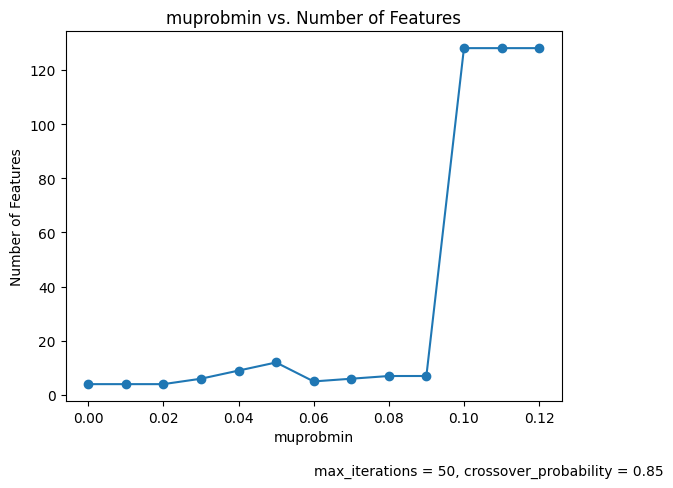

In [ ]:
plt.plot(muprobmin_arr, best_no_features_arr, marker='o')
plt.xlabel('muprobmin')
plt.ylabel('Number of Features')

# Add the values of max_iterations and crossover_probability beside the graph
plt.text(0.5, -0.2, f'max_iterations = {maxIter}, crossover_probability = {crossoverprob}',
         transform=plt.gca().transAxes)

plt.title('muprobmin vs. Number of Features')
plt.show()

In [ ]:
print(best_no_features_arr)

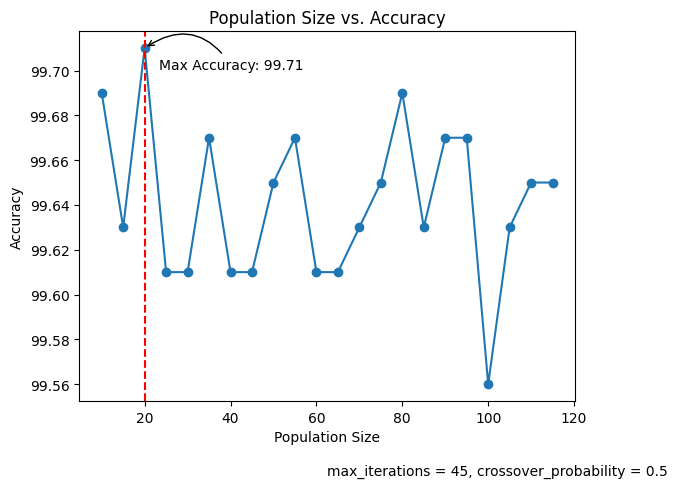

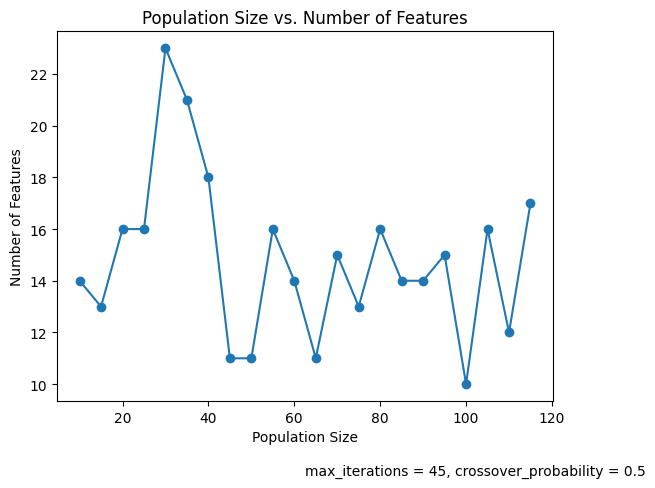

In [ ]:
import matplotlib.pyplot as plt

# Given data
population_sizes = [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 105, 110, 115]
accuracies = [99.69, 99.63, 99.71, 99.61, 99.61, 99.67, 99.61, 99.61, 99.65, 99.67, 99.61, 99.61, 99.63, 99.65, 99.69, 99.63, 99.67, 99.67, 99.56, 99.63, 99.65, 99.65]
num_features = [14, 13, 16, 16, 23, 21, 18, 11, 11, 16, 14, 11, 15, 13, 16, 14, 14, 15, 10, 16, 12, 17]
max_iterations = 45
crossover_probability = 0.5

# Population Size vs. Accuracy
plt.plot(population_sizes, accuracies, marker='o')
plt.xlabel('Population Size')
plt.ylabel('Accuracy')

# Find the index of the maximum accuracy value
max_accuracy_index = accuracies.index(max(accuracies))

# Mark the maximum accuracy value on the graph
plt.annotate(f'Max Accuracy: {accuracies[max_accuracy_index]}',
             xy=(population_sizes[max_accuracy_index], accuracies[max_accuracy_index]),
             xytext=(10, -15),
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5'))

# Add a pointer to demarcate the population size for which accuracy is maximum
plt.axvline(population_sizes[max_accuracy_index], color='r', linestyle='--')

# Add the values of max_iterations and crossover_probability beside the graph
plt.text(0.5, -0.2, f'max_iterations = {max_iterations}, crossover_probability = {crossover_probability}',
         transform=plt.gca().transAxes)

plt.title('Population Size vs. Accuracy')
plt.show()

# Population Size vs. Number of Features
plt.plot(population_sizes, num_features, marker='o')
plt.xlabel('Population Size')
plt.ylabel('Number of Features')

# Add the values of max_iterations and crossover_probability beside the graph
plt.text(0.5, -0.2, f'max_iterations = {max_iterations}, crossover_probability = {crossover_probability}',
         transform=plt.gca().transAxes)

plt.title('Population Size vs. Number of Features')
plt.show()


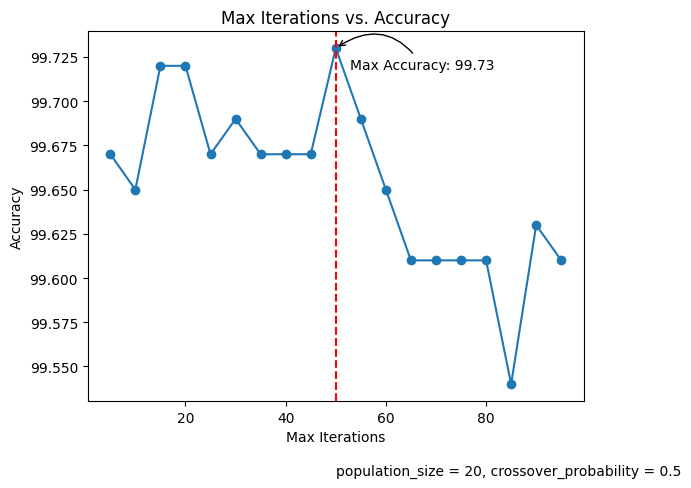

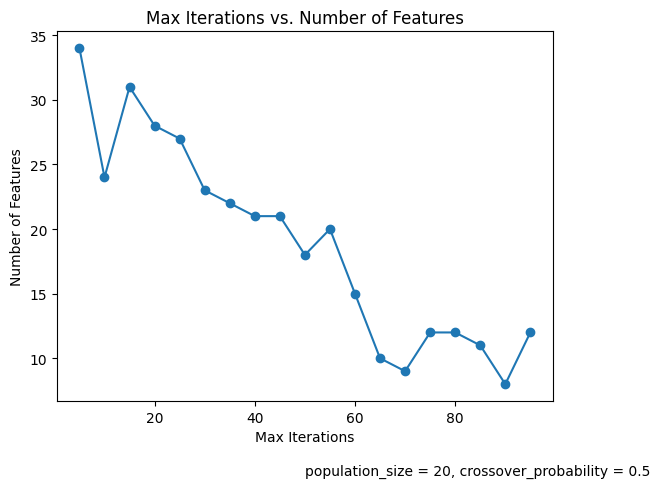

In [ ]:
import matplotlib.pyplot as plt

# Given data
iterations = [5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95]
accuracies = [99.67, 99.65, 99.72, 99.72, 99.67, 99.69, 99.67, 99.67, 99.67, 99.73, 99.69, 99.65, 99.61, 99.61, 99.61, 99.61, 99.54, 99.63, 99.61]
num_features = [34, 24, 31, 28, 27, 23, 22, 21, 21, 18, 20, 15, 10, 9, 12, 12, 11, 8, 12]
population_size = 20
crossover_probability = 0.5

# Max Iterations vs. Accuracy
plt.plot(iterations, accuracies, marker='o')
plt.xlabel('Max Iterations')
plt.ylabel('Accuracy')

# Find the index of the maximum accuracy value
max_accuracy_index = accuracies.index(max(accuracies))

# Mark the maximum accuracy value on the graph
plt.annotate(f'Max Accuracy: {accuracies[max_accuracy_index]}',
             xy=(iterations[max_accuracy_index], accuracies[max_accuracy_index]),
             xytext=(10, -15),
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5'))

# Add a vertical line to mark the maximum accuracy value
plt.axvline(x=iterations[max_accuracy_index], color='r', linestyle='--')

# Add the values of population_size and crossover_probability beside the graph
plt.text(0.5, -0.2, f'population_size = {population_size}, crossover_probability = {crossover_probability}',
         transform=plt.gca().transAxes)

plt.title('Max Iterations vs. Accuracy')
plt.show()

# Max Iterations vs. Number of Features
plt.plot(iterations, num_features, marker='o')
plt.xlabel('Max Iterations')
plt.ylabel('Number of Features')

# Add the values of population_size and crossover_probability beside the graph
plt.text(0.5, -0.2, f'population_size = {population_size}, crossover_probability = {crossover_probability}',
         transform=plt.gca().transAxes)

plt.title('Max Iterations vs. Number of Features')
plt.show()


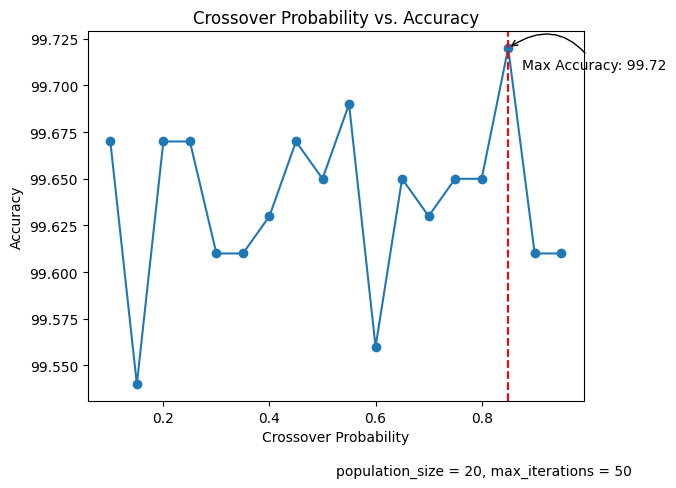

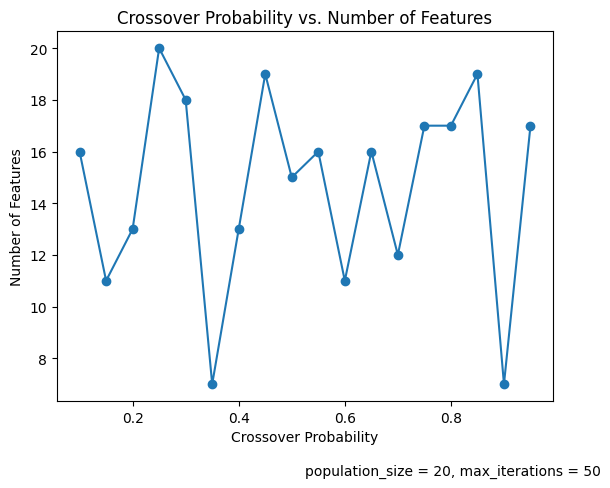

In [ ]:
import matplotlib.pyplot as plt

# Given data
crossover_probabilities = []
i = 0.1
while i < 1.0:
    crossover_probabilities.append(i)
    i += 0.05

accuracies = [99.67, 99.54, 99.67, 99.67, 99.61, 99.61, 99.63, 99.67, 99.65, 99.69, 99.56, 99.65, 99.63, 99.65, 99.65, 99.72, 99.61, 99.61]
features = [16, 11, 13, 20, 18, 7, 13, 19, 15, 16, 11, 16, 12, 17, 17, 19, 7, 17]
population_size = 20
max_iterations = 50

# Crossover Probability vs. Accuracy
plt.plot(crossover_probabilities, accuracies, marker='o')
plt.xlabel('Crossover Probability')
plt.ylabel('Accuracy')

# Find the index of the maximum accuracy value
max_accuracy_index = accuracies.index(max(accuracies))

# Mark the maximum accuracy value on the graph
plt.annotate(f'Max Accuracy: {accuracies[max_accuracy_index]}',
             xy=(crossover_probabilities[max_accuracy_index], accuracies[max_accuracy_index]),
             xytext=(10, -15),
             textcoords='offset points',
             arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.5'))

# Add a vertical line to mark the maximum accuracy value
plt.axvline(x=crossover_probabilities[max_accuracy_index], color='r', linestyle='--')

# Add the values of population_size and max_iterations beside the graph
plt.text(0.5, -0.2, f'population_size = {population_size}, max_iterations = {max_iterations}',
         transform=plt.gca().transAxes)

plt.title('Crossover Probability vs. Accuracy')
plt.show()

# Crossover Probability vs. Number of Features
plt.plot(crossover_probabilities, features, marker='o')
plt.xlabel('Crossover Probability')
plt.ylabel('Number of Features')

# Add the values of population_size and max_iterations beside the graph
plt.text(0.5, -0.2, f'population_size = {population_size}, max_iterations = {max_iterations}',
         transform=plt.gca().transAxes)

plt.title('Crossover Probability vs. Number of Features')
plt.show()


In [ ]:
 best_accuracy,best_no_features,ga,trainX_final,trainy_final,testX_final,testy_final=ga_final_vector()

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt
# !pip3 install mlxtend
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
clf=KNeighborsClassifier(n_neighbors=5)
clf.fit(trainX_final,trainy_final)
y_pred = clf.predict(testX_final)
print(y_pred)
mat = confusion_matrix(testy_final, y_pred)

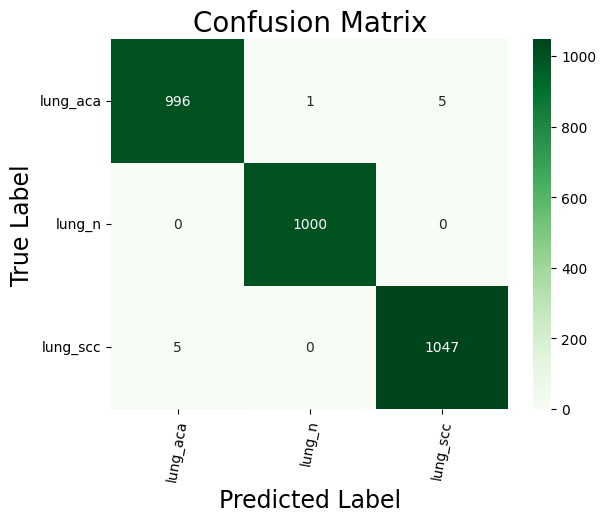

<Figure size 12000x12000 with 0 Axes>

In [ ]:
res=sn.heatmap(mat, cmap='Greens', annot=True, fmt='d')

plt.yticks([0.5,1.5,2.5], classes,rotation=0,fontsize=10)
plt.xticks([0.5,1.5,2.5], classes,rotation=80,fontsize=10)


plt.title('Confusion Matrix',fontsize=20)
plt.xlabel("Predicted Label",fontsize=17)
plt.ylabel("True Label",fontsize=17)
plt.figure(figsize=(120,120))
plt.show()

plt.close()

In [ ]:
from sklearn.metrics import classification_report
clf=KNeighborsClassifier(n_neighbors=5)
clf.fit(trainX_final,trainy_final)
y_pred = clf.predict(testX_final)
report=classification_report(testy_final,y_pred, digits=4,target_names=classes)
print(report)


              precision    recall  f1-score   support

    lung_aca     0.9973    0.9940    0.9957      1503
      lung_n     1.0000    1.0000    1.0000      1500
    lung_scc     0.9943    0.9975    0.9959      1577

    accuracy                         0.9972      4580
   macro avg     0.9972    0.9972    0.9972      4580
weighted avg     0.9972    0.9972    0.9972      4580



In [ ]:
y_pred_ = clf.predict(trainX_final)
report=classification_report(trainy_final,y_pred_, digits=4,target_names=classes)
print(report)

              precision    recall  f1-score   support

    lung_aca     0.9966    0.9937    0.9951      3507
      lung_n     0.9994    1.0000    0.9997      3500
    lung_scc     0.9946    0.9967    0.9957      3679

    accuracy                         0.9968     10686
   macro avg     0.9969    0.9968    0.9968     10686
weighted avg     0.9968    0.9968    0.9968     10686

